In [43]:
import pandas as pd
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
def load_features_from_directory(directory):
    all_features = []
    for file in tqdm(os.listdir(directory), desc="Loading feature files"):
        if file.endswith('_features.csv'):
            file_path = os.path.join(directory, file)
            features_df = pd.read_csv(file_path)
            all_features.append(features_df)
    return pd.concat(all_features, ignore_index=True)

#### Load and preprocess training data

In [ ]:
features_train_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/features/train'

train_features = load_features_from_directory(features_train_dir)

In [75]:
# Imputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(train_features)

# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# PCA
pca = PCA(n_components=0.95, random_state=0)
X_train_pca = pca.fit_transform(X_train_scaled)

#### Load and preprocess Testing data

In [ ]:
features_test_dir = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWS/data/features/test'
test_features = load_features_from_directory(features_test_dir)

In [79]:
# Impute missing values with the mean of each column for the test data, using the same imputer
X_test_imputed = imputer.transform(test_features)

# Scale the test data using the same scaler as the training data
X_test_scaled = scaler.transform(X_test_imputed)

# Apply PCA to the test data using the same PCA object as the training data
X_test_pca = pca.transform(X_test_scaled)


In [80]:
print("Shape of PCA-transformed train data:", X_train_pca.shape)
print("Shape of PCA-transformed test data:", X_test_pca.shape)

Shape of PCA-transformed train data: (1105165, 38)
Shape of PCA-transformed test data: (2674, 38)


### K-Means Clustering Algorithm

In [86]:
# Choose the number of clusters
k = 5  # Adjust this based on your analysis or use methods like the Elbow Method to find an optimal number

# Apply K-means clustering to the PCA-transformed training data
kmeans = KMeans(n_clusters=k, random_state=0, verbose=1)
train_labels = kmeans.fit_predict(X_train_pca)

# Compute cluster labels for the test data
test_labels = kmeans.predict(X_test_pca)

/usr/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 127016972.1004824.
Iteration 1, inertia 107508825.27772345.
Iteration 2, inertia 106381929.54337999.
Iteration 3, inertia 106088640.68955739.
Iteration 4, inertia 105913856.42010055.
Iteration 5, inertia 105822422.77062671.
Iteration 6, inertia 105792670.58493495.
Iteration 7, inertia 105769230.10133764.
Iteration 8, inertia 105734982.48123196.
Iteration 9, inertia 105672376.0599115.
Iteration 10, inertia 105569673.49325404.
Iteration 11, inertia 105444862.21783306.
Iteration 12, inertia 105328813.961116.
Iteration 13, inertia 105241961.85644805.
Iteration 14, inertia 105179471.10175927.
Iteration 15, inertia 105132859.32027774.
Iteration 16, inertia 105095868.03182164.
Iteration 17, inertia 105064216.38921486.
Iteration 18, inertia 105039587.32158338.
Iteration 19, inertia 105019280.4482612.
Iteration 20, inertia 105002239.45327806.
Iteration 21, inertia 104987411.88320573.
Iteration 22, inertia 104973136.99533609.
Iteration 23, inertia 104

In [92]:
# Print cluster labels for training data
print("Training Data Cluster Labels:")
print(train_labels)

# Print cluster labels for test data
print("Test Data Cluster Labels:")
print(test_labels)

Training Data Cluster Labels:
[1 1 1 ... 4 1 1]


#### K-Means Visualization

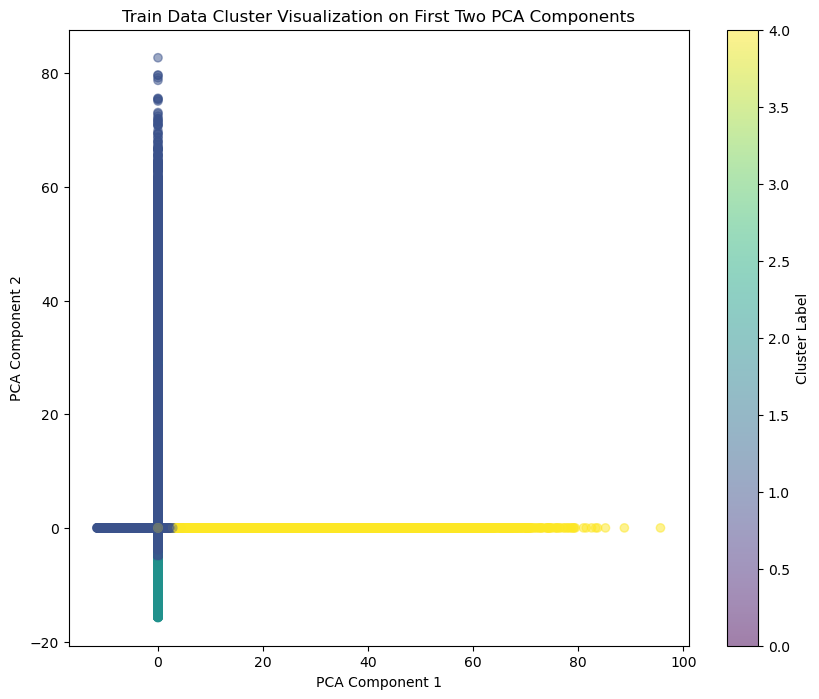

In [90]:
# Scatter plot for the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_labels, cmap='viridis', alpha=0.5)
plt.title('Train Data Cluster Visualization on First Two PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


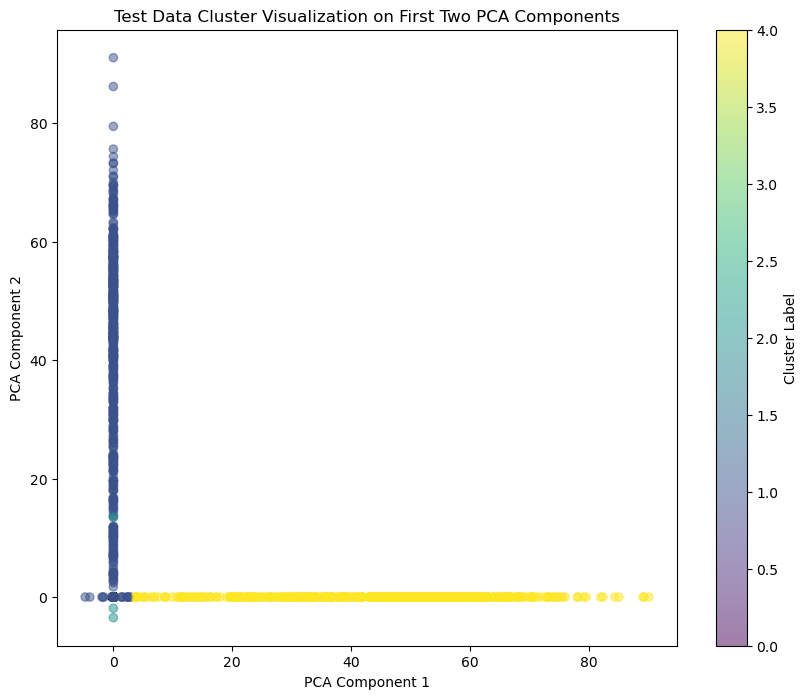

In [89]:
# Ensure you have at least 2 PCA components to plot
if X_test_pca.shape[1] >= 2:
    plt.figure(figsize=(10, 8))
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_labels, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Cluster Label')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Test Data Cluster Visualization on First Two PCA Components')
    plt.show()


In [83]:
from collections import Counter

# Count how many test data points fall into each cluster
test_cluster_distribution = Counter(test_labels)
print("Test data cluster distribution:")
print(test_cluster_distribution)


Test data cluster distribution:
Counter({1: 1178, 4: 544, 3: 480, 0: 468, 2: 4})


In [84]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for the test data
test_silhouette_avg = silhouette_score(X_test_pca, test_labels)
print("For the test set, the average silhouette_score is:", test_silhouette_avg)


For the test set, the average silhouette_score is: 0.17466506282231148


In [85]:
def calculate_test_centroids(X, labels, num_clusters):
    centroids = []
    for i in range(num_clusters):
        cluster_points = X[labels == i]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
    return np.array(centroids)

test_centroids = calculate_test_centroids(X_test_pca, test_labels, k)
print("Test data centroids (in PCA-transformed space):")
print(test_centroids)


Test data centroids (in PCA-transformed space):
[[-2.86325161e-15  3.39019949e-15  5.14380813e+01 -1.44435108e-12
   1.57955803e-12  2.69414761e-13 -9.61248910e-14  3.02692400e+01
  -9.77882768e-15  4.62947079e-14 -6.71373488e-15  7.78415073e-14
   8.96379258e-15  3.60622539e+00 -3.07454471e-14 -5.26121114e+00
   1.17294843e-16 -1.25117555e-13 -2.14296390e-14 -4.63144407e-14
   3.69866478e-15  1.01164713e-13 -5.43488498e-14  7.35734165e-13
   6.84429846e-01 -5.13954799e-14  1.45623375e-13 -6.35770448e-15
   3.21516154e+00 -1.58860598e-13 -4.26035714e-14 -3.29875942e+00
   3.74027648e-14 -6.65388517e-15 -1.09618414e-14 -1.20205529e-14
   9.51560089e-15  9.51346772e+00]
 [ 2.24026131e-03  1.89827728e+01  4.96675808e-01  2.82951163e+00
   2.48277490e-01  2.59779842e+01  2.71201053e-01  5.52588049e-01
   1.77303250e+01  1.07862785e-01 -9.74405079e-01  3.92619940e-01
   1.72674604e-02  3.83314750e-03  4.39562540e-03 -1.18231723e-02
   1.62022551e-03  1.97630362e+00  2.09991299e+00 -7.015507